# **ATTIC DATA SCIENCE COMPONENT**

## **Importing Required Libraries**

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
image_dir = Path('/content/drive/MyDrive/House_Room_Dataset')

# **Creating File DataFrames**

In [ ]:
print(len(list(image_dir.glob(r'**/*.jpg'))))

3528


In [ ]:
filepaths = list(image_dir.glob(r'**/*.jpg'))

In [ ]:
filepaths

[PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_510.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_404.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_585.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_120.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_279.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_499.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_384.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_1065.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_385.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_1095.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Dataset/train/Diningroom/din_1073.jpg'),
 PosixPath('/content/drive/MyDrive/House_Room_Datas

# **Capturing the Labels**
######Labels are captured by splitting the file paths
###### Then the captured labels and their count is turned to a DataFrame
 

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)
image_df['Label'].value_counts()

Diningroom    1188
Livingroom    1170
Bedroom       1170
Name: Label, dtype: int64

## **Selecting 1000 Random Images for each Class**
######Create a empty lis of samples and check for labels
######Take 1000 random images and append to samples list and shuffle them
######Then look for the value count for each class



In [ ]:
samples = []
for category in image_df['Label'].unique():
  category_slice = image_df.query("Label == @category")
  samples.append(category_slice.sample(1000, random_state=1))
image_df = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
image_df['Label'].value_counts()

Livingroom    1000
Diningroom    1000
Bedroom       1000
Name: Label, dtype: int64

# **Loading Images**

## Train Test Split using sklearn with train size of 70% and shuffle them

In [ ]:
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

## Preprocessing the input using ImageDataGenerator with relavent to MobileNetV2 architecture

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

## Images are gathered using flow_from_dataframe


1.   dataframes are initalized as train_df/test_df
2.  define columns
3. declare the target image size as 224x224
4. class mode is categorical due to presence of many classes
5. batch size is set to 32
6. shuffle the data for training and valiation and not for test
7. subset named training/validation is created



In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe = train_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = True,
    seed = 42,
    subset = 'validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe = test_df,
    x_col = 'Filepath',
    y_col = 'Label',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'categorical',
    batch_size = 32,
    shuffle = False
)

Found 1680 validated image filenames belonging to 3 classes.
Found 420 validated image filenames belonging to 3 classes.
Found 900 validated image filenames belonging to 3 classes.


# **Training**
### Input shape is 224
### Top of the network usually refers to the output hence it is negelected and use a top for 3 required classes
### MobileNet is initally trained on ImageNet dataset. Therefore those weights are added.
### Declaring all the parameters as non-trainable

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape = (224,224,3),
    include_top = False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

pretrained_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

# **Feature Extraction**
##### Two hidden dense layers are added
##### Train the model using adam optimizer, loss function as categorial_crossentropy
##### 100 epochs on train_images and validation on validation_images
##### If there is no improvement in validation_loss after 3 consecutive epochs, model will stop training.

In [ ]:
inputs = pretrained_model.input
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [
      tf.keras.callbacks.EarlyStopping(
          monitor = 'val_loss',
          patience = 3,
          restore_best_weights = True
          )
    ]
)

Epoch 1/100
53/53 [==============================] - 890s 16s/step - loss: 0.6845 - accuracy: 0.6833 - val_loss: 0.4264 - val_accuracy: 0.8238
Epoch 2/100
53/53 [==============================] - 13s 234ms/step - loss: 0.2733 - accuracy: 0.8952 - val_loss: 0.4180 - val_accuracy: 0.8357
Epoch 3/100
53/53 [==============================] - 13s 240ms/step - loss: 0.1865 - accuracy: 0.9366 - val_loss: 0.4042 - val_accuracy: 0.8500
Epoch 4/100
53/53 [==============================] - 13s 239ms/step - loss: 0.1805 - accuracy: 0.9386 - val_loss: 0.5090 - val_accuracy: 0.8262
Epoch 5/100
53/53 [==============================] - 12s 238ms/step - loss: 0.1619 - accuracy: 0.9481 - val_loss: 0.4677 - val_accuracy: 0.8524
Epoch 6/100
53/53 [==============================] - 12s 238ms/step - loss: 0.0870 - accuracy: 0.9714 - val_loss: 0.4892 - val_accuracy: 0.8548


In [ ]:
class_names = list(test_images.class_indices.keys())
class_names

['Bedroom', 'Diningroom', 'Livingroom']

# **Testing Metrics**

29/29 [==============================] - 365s 13s/step - loss: 0.3462 - accuracy: 0.8567
Test Accuracy: 85.67%


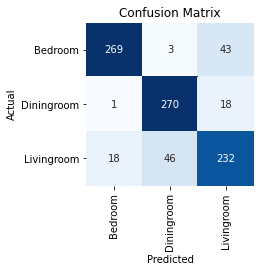

Classification Report:
-------------------
               precision    recall  f1-score   support

     Bedroom       0.93      0.85      0.89       315
  Diningroom       0.85      0.93      0.89       289
  Livingroom       0.79      0.78      0.79       296

    accuracy                           0.86       900
   macro avg       0.86      0.86      0.86       900
weighted avg       0.86      0.86      0.86       900



In [ ]:
results = model.evaluate(test_images, verbose = 1)
predictions = np.argmax(model.predict(test_images), axis = 1)

class_names = list(test_images.class_indices.keys())
cm = confusion_matrix(test_images.labels, predictions, labels = np.arange(3))
clr = classification_report(test_images.labels, predictions, labels = np.arange(3), target_names = class_names)

print("Test Accuracy: {:.2f}%".format(results[1] * 100))
plt.figure(figsize = (3,3))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
plt.xticks(ticks=np.arange(3) + 0.5, labels=class_names, rotation=90)
plt.yticks(ticks=np.arange(3) + 0.5, labels=class_names, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n-------------------\n", clr)

## **Curves**

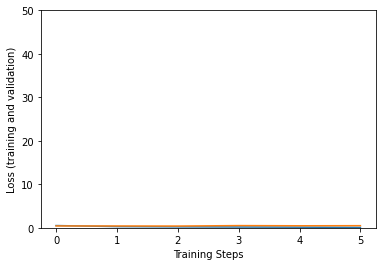

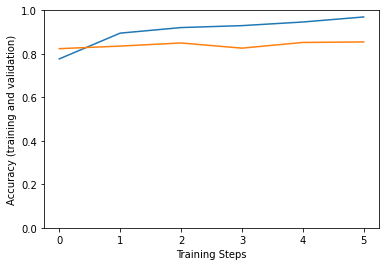

In [ ]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,50])
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

# **Saving the Model**

In [ ]:
from tensorflow.keras.models import load_model

model.save('room_scenes(ssd).h5')

# **Converting to Tensorflow Lite**

In [ ]:
import tensorflow as tf

tflite_model = tf.keras.models.load_model('/content/room_scenes(ssd).h5')
converter = tf.lite.TFLiteConverter.from_keras_model(tflite_model)
tflite_save = converter.convert()
open("rooms_scenes.tflite", "wb").write(tflite_save)

INFO:tensorflow:Assets written to: /tmp/tmp45feew4n/assets


9582732

## **Testing with Images**

In [ ]:
val_image_batch, val_label_batch = next(iter(test_images))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [ ]:
dataset_labels = sorted(test_images.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

['Bedroom' 'Diningroom' 'Livingroom']


In [ ]:
tf_model_predictions = model.predict(val_image_batch)
print("Prediction results shape:", tf_model_predictions.shape)

Prediction results shape: (32, 3)


In [ ]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]

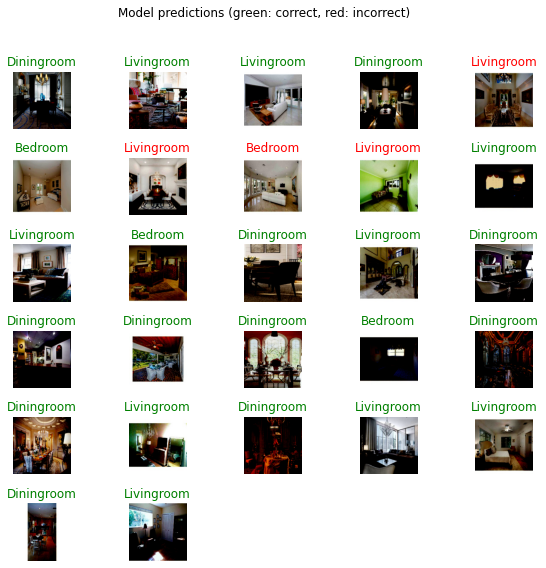

In [ ]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range((len(test_images)-2)):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")